Original file is located at
    https://colab.research.google.com/github/bastings/annotated_encoder_decoder/blob/master/annotated_encoder_decoder.ipynb

Automatically generated by Colaboratory.

Recently, Alexander Rush wrote a blog post called [The Annotated Transformer](http://nlp.seas.harvard.edu/2018/04/03/attention.html), describing the Transformer model from the paper [Attention is All You Need](https://arxiv.org/abs/1706.03762). This post can be seen as a **prequel** to that: *we will implement an Encoder-Decoder with Attention* using (Gated) Recurrent Neural Networks, very closely following the original attention-based neural machine translation paper ["Neural Machine Translation by Jointly Learning to Align and Translate"](https://arxiv.org/abs/1409.0473) of Bahdanau et al. (2015).


Model Architecture

The idea is that going through both blog posts will make you familiar with two very influential sequence-to-sequence architectures. If you have any comments or suggestions, please let me know on Twitter [@joostbastings](https://twitter.com/joostbastings) or e-mail me at *firstname dot lastname @ gmail dot com*.

The Annotated Encoder-Decoder with Attention

We will model the probability $p(Y\mid X)$ of a target sequence $Y=(y_1, \dots, y_{N})$ given a source sequence $X=(x_1, \dots, x_M)$ directly with a neural network: an Encoder-Decoder.

<img src="images/bahdanau.png" width="636">

## Encoder

The encoder reads in the source sentence (*at the bottom of the figure*) and produces a sequence of hidden states $\mathbf{h}_1, \dots, \mathbf{h}_M$, one for each source word. These states should capture the meaning of a word in its context of the given sentence.

We will use a bi-directional recurrent neural network (Bi-RNN) as the encoder; a Bi-GRU in particular.

First of all we **embed** the source words.
We simply look up the **word embedding** for each word in a (randomly initialized) lookup table.
We will denote the word embedding for word $i$ in a given sentence with $\mathbf{x}_i$.
By embedding words, our model may exploit the fact that certain words (e.g. *cat* and *dog*) are semantically similar, and can be processed in a similar way.

Now, how do we get hidden states $\mathbf{h}_1, \dots, \mathbf{h}_M$? A forward GRU reads the source sentence left-to-right, while a backward GRU reads it right-to-left.
Each of them follows a simple recursive formula:
$$\mathbf{h}_j = \text{GRU}( \mathbf{x}_j , \mathbf{h}_{j - 1} )$$
i.e. we obtain the next state from the previous state and the current input word embedding.

The hidden state of the forward GRU at time step $j$ will know what words **precede** the word at that time step, but it doesn't know what words will follow. In contrast, the backward GRU will only know what words **follow** the word at time step $j$. By **concatenating** those two hidden states (*shown in blue in the figure*), we get $\mathbf{h}_j$, which captures word $j$ in its full sentence context.

## Decoder

The decoder (*at the top of the figure*) is a GRU with hidden state $\mathbf{s_i}$. It follows a similar formula to the encoder, but takes one extra input $\mathbf{c}_{i}$ (*shown in yellow*).

$$\mathbf{s}_{i} = f( \mathbf{s}_{i - 1}, \mathbf{y}_{i - 1}, \mathbf{c}_i )$$

Here, $\mathbf{y}_{i - 1}$ is the previously generated target word (*not shown*).

At each time step, an **attention mechanism** dynamically selects that part of the source sentence that is most relevant for predicting the current target word. It does so by comparing the last decoder state with each source hidden state. The result is a context vector $\mathbf{c_i}$ (*shown in yellow*).
Later the attention mechanism is explained in more detail.

After computing the decoder state $\mathbf{s}_i$, a non-linear function $g$ (which applies a [softmax](https://en.wikipedia.org/wiki/Softmax_function)) gives us the probability of the target word $y_i$ for this time step:
$$ p(y_i \mid y_{<i}, x_1^M) = g(\mathbf{s}_i, \mathbf{c}_i, \mathbf{y}_{i - 1})$$

Because $g$ applies a softmax, it provides a vector the size of the output vocabulary that sums to 1.0: it is a distribution over all target words. During test time, we would select the word with the highest probability for our translation.

Now, for optimization, a [cross-entropy loss](https://ml-cheatsheet.readthedocs.io/en/latest/loss_functions.html#cross-entropy) is used to maximize the probability of selecting the correct word at this time step. All parameters (including word embeddings) are then updated to maximize this probability.

Prelims

This tutorial requires **PyTorch >= 0.4.1** and was tested with **Python 3.6**.

Make sure you have those versions, and install the packages below if you don't have them yet.
"""

In [100]:
!pip install --upgrade torch numpy matplotlib sacrebleu

Requirement already up-to-date: torch in /usr/local/lib/python3.6/dist-packages (1.3.1)
Requirement already up-to-date: numpy in /usr/local/lib/python3.6/dist-packages (1.17.4)
Requirement already up-to-date: matplotlib in /usr/local/lib/python3.6/dist-packages (3.1.2)
Requirement already up-to-date: sacrebleu in /usr/local/lib/python3.6/dist-packages (1.4.3)


In [0]:
import copy
import math
import time
import matplotlib.pyplot as plt

Commented out IPython magic to ensure Python compatibility.

In [0]:
import numpy as np
#import sacrebleu
import torch
import torch.nn as nn
import torch.nn.functional as F
from IPython.core.debugger import set_trace
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

For data loading.<br>
from torchtext import data, datasets

we will use CUDA if it is available

In [103]:
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda:0")  # or set to 'cpu'
print("CUDA:", USE_CUDA)
print(DEVICE)

CUDA: False
cuda:0


In [0]:
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)


# Let's start coding!<br>
## Model class<br>
Our base model class `EncoderDecoder` is very similar to the one in *The Annotated Transformer*.<br>
One difference is that our encoder also returns its final states (`encoder_final` below), which is used to initialize the decoder RNN. We also provide the sequence lengths as the RNNs require those.<br>


In [0]:
class EncoderDecoder(nn.Module):
    """
    A standard Encoder-Decoder architecture. Base for this and many
    other models.
    """
    def __init__(self, encoder, decoder, src_embed, trg_embed, generator):
        super(EncoderDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_embed = src_embed
        self.trg_embed = trg_embed
        self.generator = generator
    def forward(self, src, trg, src_mask, trg_mask, src_lengths, trg_lengths):
        """Take in and process masked src and target sequences."""
        encoder_hidden, encoder_final = self.encode(src, src_mask, src_lengths)
        return self.decode(
            encoder_hidden, encoder_final, src_mask, trg, trg_mask
        )
    def encode(self, src, src_mask, src_lengths):
        return self.encoder(self.src_embed(src), src_mask, src_lengths)
    def decode(
        self,
        encoder_hidden,
        encoder_final,
        src_mask,
        trg,
        trg_mask,
        decoder_hidden=None,
        max_len=None,
    ):
        return self.decoder(
            self.trg_embed(trg),
            encoder_hidden,
            encoder_final,
            src_mask,
            trg_mask,
            hidden=decoder_hidden,
            max_len=max_len,
        )


To keep things easy we also keep the `Generator` class the same.<br>
It simply projects the pre-output layer ($x$ in the `forward` function below) to obtain the output layer, so that the final dimension is the target vocabulary size.<br>


In [0]:
class Generator(nn.Module):
    """Define standard linear + softmax generation step."""
    def __init__(self, hidden_size, vocab_size):
        super(Generator, self).__init__()
        self.proj = nn.Linear(hidden_size, vocab_size, bias=False)
    def forward(self, x):
        return F.log_softmax(self.proj(x), dim=-1)


## Encoder<br>
Our encoder is a bi-directional GRU.<br>
Because we want to process multiple sentences at the same time for speed reasons (it is more effcient on GPU), we need to support **mini-batches**. Sentences in a mini-batch may have different lengths, which means that the RNN needs to unroll further for certain sentences while it might already have finished for others:<br>
```<br>
Example: mini-batch with 3 source sentences of different lengths (7, 5, and 3).<br>
End-of-sequence is marked with a "3" here, and padding positions with "1".<br>
+---------------+<br>
| 4 5 9 8 7 8 3 |<br>
+---------------+<br>
| 5 4 8 7 3 1 1 |<br>
+---------------+<br>
| 5 8 3 1 1 1 1 |<br>
+---------------+<br>
```<br>
You can see that, when computing hidden states for this mini-batch, for sentence #2 and #3 we will need to stop updating the hidden state after we have encountered "3". We don't want to incorporate the padding values (1s).<br>
Luckily, PyTorch has convenient helper functions called `pack_padded_sequence` and `pad_packed_sequence`.<br>
These functions take care of masking and padding, so that the resulting word representations are simply zeros after a sentence stops.<br>
The code below reads in a source sentence (a sequence of word embeddings) and produces the hidden states.<br>
It also returns a final vector, a summary of the complete sentence, by concatenating the first and the last hidden states (they have both seen the whole sentence, each in a different direction). We will use the final vector to initialize the decoder.<br>


In [0]:
class Encoder(nn.Module):
    """Encodes a sequence of word embeddings"""
    def __init__(self, input_size, hidden_size, num_layers=1, dropout=0.0):
        super(Encoder, self).__init__()
        self.num_layers = num_layers
        self.rnn = nn.GRU(
            input_size,
            hidden_size,
            num_layers,
            batch_first=True,
            bidirectional=True,
            dropout=dropout,
        )
    def forward(self, x, mask, lengths):
        """
        Applies a bidirectional GRU to sequence of embeddings x.
        The input mini-batch x needs to be sorted by length.
        x should have dimensions [batch, time, dim].
        """
        packed = pack_padded_sequence(
            x, lengths, batch_first=True, enforce_sorted=False
        )
        output, final = self.rnn(packed)
        output, _ = pad_packed_sequence(
            output, batch_first=True, padding_value=0
        )

        # we need to manually concatenate the final states for both directions
        fwd_final = final[0 : final.size(0) : 2]
        bwd_final = final[1 : final.size(0) : 2]
        final = torch.cat(
            [fwd_final, bwd_final], dim=2
        )  # [num_layers, batch, 2*dim]
        return output, final


### Decoder<br>
The decoder is a conditional GRU. Rather than starting with an empty state like the encoder, its initial hidden state results from a projection of the encoder final vector.<br>
#### Training<br>
In `forward` you can find a for-loop that computes the decoder hidden states one time step at a time.<br>
Note that, during training, we know exactly what the target words should be! (They are in `trg_embed`.) This means that we are not even checking here what the prediction is! We simply feed the correct previous target word embedding to the GRU at each time step. This is called teacher forcing.<br>
The `forward` function returns all decoder hidden states and pre-output vectors. Elsewhere these are used to compute the loss, after which the parameters are updated.<br>
#### Prediction<br>
For prediction time, for forward function is only used for a single time step. After predicting a word from the returned pre-output vector, we can call it again, supplying it the word embedding of the previously predicted word and the last state.<br>


In [0]:
class Decoder(nn.Module):
    """A conditional RNN decoder with attention."""
    def __init__(
        self,
        emb_size,
        hidden_size,
        attention,
        num_layers=1,
        dropout=0.5,
        bridge=True,
    ):
        super(Decoder, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.attention = attention
        self.dropout = dropout
        self.rnn = nn.GRU(
            emb_size + 2 * hidden_size,
            hidden_size,
            num_layers,
            batch_first=True,
            dropout=dropout,
        )

        # to initialize from the final encoder state
        self.bridge = (
            nn.Linear(2 * hidden_size, hidden_size, bias=True)
            if bridge
            else None
        )
        self.dropout_layer = nn.Dropout(p=dropout)
        self.pre_output_layer = nn.Linear(
            hidden_size + 2 * hidden_size + emb_size, hidden_size, bias=False
        )
    def forward_step(
        self, prev_embed, encoder_hidden, src_mask, proj_key, hidden
    ):
        """Perform a single decoder step (1 word)"""

        # compute context vector using attention mechanism
        query = hidden[-1].unsqueeze(1)  # [#layers, B, D] -> [B, 1, D]
        context, attn_probs = self.attention(
            query=query, proj_key=proj_key, value=encoder_hidden, mask=src_mask
        )

        # update rnn hidden state
        rnn_input = torch.cat([prev_embed, context], dim=2)
        output, hidden = self.rnn(rnn_input, hidden)
        pre_output = torch.cat([prev_embed, output, context], dim=2)
        pre_output = self.dropout_layer(pre_output)
        pre_output = self.pre_output_layer(pre_output)
        return output, hidden, pre_output
    def forward(
        self,
        trg_embed,
        encoder_hidden,
        encoder_final,
        src_mask,
        trg_mask,
        hidden=None,
        max_len=None,
    ):
        """Unroll the decoder one step at a time."""

        # the maximum number of steps to unroll the RNN
        if max_len is None:
            max_len = trg_mask.size(-1)

        # initialize decoder hidden state
        if hidden is None:
            hidden = self.init_hidden(encoder_final)

        # pre-compute projected encoder hidden states
        # (the "keys" for the attention mechanism)
        # this is only done for efficiency
        proj_key = self.attention.key_layer(encoder_hidden)

        # here we store all intermediate hidden states and pre-output vectors
        decoder_states = []
        pre_output_vectors = []

        # unroll the decoder RNN for max_len steps
        for i in range(max_len):
            prev_embed = trg_embed[:, i].unsqueeze(1)
            output, hidden, pre_output = self.forward_step(
                prev_embed, encoder_hidden, src_mask, proj_key, hidden
            )
            decoder_states.append(output)
            pre_output_vectors.append(pre_output)
        decoder_states = torch.cat(decoder_states, dim=1)
        pre_output_vectors = torch.cat(pre_output_vectors, dim=1)
        return decoder_states, hidden, pre_output_vectors  # [B, N, D]
    def init_hidden(self, encoder_final):
        """Returns the initial decoder state,
        conditioned on the final encoder state."""
        if encoder_final is None:
            return None  # start with zeros
        return torch.tanh(self.bridge(encoder_final))


### Attention<br>
At every time step, the decoder has access to *all* source word representations $\mathbf{h}_1, \dots, \mathbf{h}_M$.<br>
An attention mechanism allows the model to focus on the currently most relevant part of the source sentence.<br>
The state of the decoder is represented by GRU hidden state $\mathbf{s}_i$.<br>
So if we want to know which source word representation(s) $\mathbf{h}_j$ are most relevant, we will need to define a function that takes those two things as input.<br>
Here we use the MLP-based, additive attention that was used in Bahdanau et al.:<br>
<img src="images/attention.png" width="280"><br>
We apply an MLP with tanh-activation to both the current decoder state $\bf s_i$ (the *query*) and each encoder state $\bf h_j$ (the *key*), and then project this to a single value (i.e. a scalar) to get the *attention energy* $e_{ij}$.<br>
Once all energies are computed, they are normalized by a softmax so that they sum to one:<br>
$$ \alpha_{ij} = \text{softmax}(\mathbf{e}_i)[j] $$<br>
$$\sum_j \alpha_{ij} = 1.0$$<br>
The context vector for time step $i$ is then a weighted sum of the encoder hidden states (the *values*):<br>
$$\mathbf{c}_i = \sum_j \alpha_{ij} \mathbf{h}_j$$<br>


In [0]:
class BahdanauAttention(nn.Module):
    """Implements Bahdanau (MLP) attention"""
    def __init__(self, hidden_size, key_size=None, query_size=None):
        super(BahdanauAttention, self).__init__()

        # We assume a bi-directional encoder so key_size is 2*hidden_size
        key_size = 2 * hidden_size if key_size is None else key_size
        query_size = hidden_size if query_size is None else query_size
        self.key_layer = nn.Linear(key_size, hidden_size, bias=False)
        self.query_layer = nn.Linear(query_size, hidden_size, bias=False)
        self.energy_layer = nn.Linear(hidden_size, 1, bias=False)

        # to store attention scores
        self.alphas = None
    def forward(self, query=None, proj_key=None, value=None, mask=None):
        assert mask is not None, "mask is required"

        # We first project the query (the decoder state).
        # The projected keys (the encoder states) were already pre-computated.
        query = self.query_layer(query)

        # Calculate scores.
        scores = self.energy_layer(torch.tanh(query + proj_key))
        scores = scores.squeeze(2).unsqueeze(1)

        # Mask out invalid positions.
        # The mask marks valid positions so we invert it using `mask & 0`.
        scores.data.masked_fill_(mask == 0, -float("inf"))

        # Turn scores to probabilities.
        alphas = F.softmax(scores, dim=-1)
        self.alphas = alphas

        # The context vector is the weighted sum of the values.
        context = torch.bmm(alphas, value)

        # context shape: [B, 1, 2D], alphas shape: [B, 1, M]
        return context, alphas


## Embeddings and Softmax<br>
We use learned embeddings to convert the input tokens and output tokens to vectors of dimension `emb_size`.<br>
We will simply use PyTorch's [nn.Embedding](https://pytorch.org/docs/stable/nn.html?highlight=embedding#torch.nn.Embedding) class.<br>
## Full Model<br>
Here we define a function from hyperparameters to a full model.<br>


In [0]:
def make_model(
    src_vocab,
    tgt_vocab,
    emb_size=256,
    hidden_size=512,
    num_layers=1,
    dropout=0.1,
):
    "Helper: Construct a model from hyperparameters."
    attention = BahdanauAttention(hidden_size)
    model = EncoderDecoder(
        Encoder(emb_size, hidden_size, num_layers=num_layers, dropout=dropout),
        Decoder(
            emb_size,
            hidden_size,
            attention,
            num_layers=num_layers,
            dropout=dropout,
        ),
        nn.Embedding(src_vocab, emb_size, padding_idx=0),
        nn.Embedding(tgt_vocab, emb_size, padding_idx=0),
        Generator(hidden_size, tgt_vocab),
    )
    return model.cuda() if USE_CUDA else model


# Training<br>
This section describes the training regime for our models.<br>
We stop for a quick interlude to introduce some of the tools<br>
needed to train a standard encoder decoder model. First we define a batch object that holds the src and target sentences for training, as well as their lengths and masks.<br>
## Batches and Masking<br>


In [0]:
class Batch:
    """Object for holding a batch of data with mask during training.
    Input is a batch from a torch text iterator.
    """
    def __init__(self, src, trg, pad_index=0):
        src, src_lengths = src
        self.src = src
        self.src_lengths = src_lengths
        self.src_mask = (src != pad_index).unsqueeze(-2)
        self.nseqs = src.size(0)
        self.trg = None
        self.trg_y = None
        self.trg_mask = None
        self.trg_lengths = None
        self.ntokens = None
        if trg is not None:
            trg, trg_lengths = trg
            self.trg = trg[:, :-1]
            self.trg_lengths = trg_lengths
            self.trg_y = trg[:, 1:]
            self.trg_mask = self.trg_y != pad_index
            self.ntokens = (self.trg_y != pad_index).data.sum().item()
        if USE_CUDA:
            self.src = self.src.cuda()
            self.src_mask = self.src_mask.cuda()
            if trg is not None:
                self.trg = self.trg.cuda()
                self.trg_y = self.trg_y.cuda()
                self.trg_mask = self.trg_mask.cuda()


## Training Loop<br>
The code below trains the model for 1 epoch (=1 pass through the training data).<br>


In [0]:
def run_epoch(data_iter, model, loss_compute, print_every=50):
    """Standard Training and Logging Function"""
    start = time.time()
    total_tokens = 0
    total_loss = 0
    print_tokens = 0
    for i, batch in enumerate(data_iter, 1):
        out, _, pre_output = model.forward(
            batch.src,
            batch.trg,
            batch.src_mask,
            batch.trg_mask,
            batch.src_lengths,
            batch.trg_lengths,
        )
        loss = loss_compute(pre_output, batch.trg_y, batch.nseqs)
        total_loss += loss
        total_tokens += batch.ntokens
        print_tokens += batch.ntokens
        if model.training and i % print_every == 0:
            elapsed = time.time() - start
            print(
                "Epoch Step: %d Loss: %f Tokens per Sec: %f"
                % (i, loss / batch.nseqs, print_tokens / elapsed)
            )
            start = time.time()
            print_tokens = 0
    return math.exp(total_loss / float(total_tokens))


## Training Data and Batching<br>
We will use torch text for batching. This is discussed in more detail below.<br>
## Optimizer<br>
We will use the [Adam optimizer](https://arxiv.org/abs/1412.6980) with default settings ($\beta_1=0.9$, $\beta_2=0.999$ and $\epsilon=10^{-8}$).<br>
We will use $0.0003$ as the learning rate here, but for different problems another learning rate may be more appropriate. You will have to tune that.<br>
# A First  Example<br>
We can begin by trying out a simple copy-task. Given a random set of input symbols from a small vocabulary, the goal is to generate back those same symbols.<br>
## Synthetic Data<br>


In [0]:
target_to_text = {
    "0": "0",
    "1": "1",
    "2": "two",
    "3": "three",
    "4": "four",
    "5": "five",
    "6": "six",
    "7": "seven",
    "8": "eight",
    "9": "nine",
}
input_characters = " ".join(target_to_text.values())
valid_characters = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9",] + list(
    set(input_characters)
)

In [0]:
src_vocab_len = len(valid_characters)
trg_vocab_len = len(target_to_text.keys())

In [0]:
def data_gen(
    num_words=9,
    batch_size=16,
    num_batches=100,
    min_length=3,
    max_length=8,
    pad_index=0,
    eos_index=1,
    sos_index=1,
):
    """Generate random data for a src-tgt copy task."""
    for i in range(num_batches):
        data = [
            np.random.randint(
                2,
                num_words,
                size=(np.random.randint(min_length, max_length + 1)),
            )
            for i in range(batch_size)
        ]
        for arr in data:
            arr[-1] = eos_index
            arr[0] = sos_index
        trg_max_length = max([len(i) for i in data])
        tmp = np.zeros((batch_size, trg_max_length), dtype="int64")
        trg_lengths = []
        for i, arr in enumerate(data):
            cur_len = len(arr)
            trg_lengths.append(cur_len)
            tmp[i, :cur_len] = arr
        data = tmp
        src = [
            [
                target_to_text[str(x)]
                for x in i
                if x not in (pad_index, eos_index, sos_index)
            ]
            for i in data
        ]
        src = [[valid_characters.index(el) for el in " ".join(y)] for y in src]
        src_max_len = max([len(i) for i in src])
        src_lengths = []
        tmp = np.zeros((batch_size, src_max_len), dtype="int64")
        for i, arr in enumerate(src):
            cur_len = len(arr)
            src_lengths.append(cur_len)
            tmp[i, :cur_len] = arr
        src = torch.from_numpy(tmp)
        data = torch.from_numpy(data)
        data = data.cuda() if USE_CUDA else data
        trg = data
        yield Batch(
            (torch.LongTensor(src), src_lengths),
            (torch.LongTensor(trg), trg_lengths),
            pad_index=pad_index,
        )


## Loss Computation
  
A simple loss compute and train function.


In [0]:
class SimpleLossCompute:
    def __init__(self, generator, criterion, opt=None):
        self.generator = generator
        self.criterion = criterion
        self.opt = opt
    def __call__(self, x, y, norm):
        x = self.generator(x)
        loss = self.criterion(
            x.contiguous().view(-1, x.size(-1)), y.contiguous().view(-1)
        )
        loss = loss / norm
        if self.opt is not None:
            loss.backward()
            self.opt.step()
            self.opt.zero_grad()
        return loss.data.item() * norm


### Printing examples<br>
To monitor progress during training, we will translate a few examples.<br>
We use greedy decoding for simplicity; that is, at each time step, starting at the first token, we choose the one with that maximum probability, and we never revisit that choice.<br>


In [0]:
def greedy_decode(
    model, src, src_mask, src_lengths, max_len=100, sos_index=1, eos_index=1
):
    """Greedily decode a sentence."""
    with torch.no_grad():
        encoder_hidden, encoder_final = model.encode(src, src_mask, src_lengths)
        prev_y = torch.ones(1, 1).fill_(sos_index).type_as(src)
        trg_mask = torch.ones_like(prev_y)
    output = []
    attention_scores = []
    hidden = None
    for i in range(max_len):
        with torch.no_grad():
            out, hidden, pre_output = model.decode(
                encoder_hidden,
                encoder_final,
                src_mask,
                prev_y,
                trg_mask,
                hidden,
            )

            # we predict from the pre-output layer, which is
            # a combination of Decoder state, prev emb, and context
            prob = model.generator(pre_output[:, -1])
        _, next_word = torch.max(prob, dim=1)
        next_word = next_word.data.item()
        output.append(next_word)
        prev_y = torch.ones(1, 1).type_as(src).fill_(next_word)
        attention_scores.append(model.decoder.attention.alphas.cpu().numpy())
    output = np.array(output)

    # cut off everything starting from </s>
    # (only when eos_index provided)
    if eos_index is not None:
        first_eos = np.where(output == eos_index)[0]
        if len(first_eos) > 0:
            output = output[: first_eos[0]]
    return output, np.concatenate(attention_scores, axis=1)

In [0]:
def lookup_words(x, vocab=None):
    if vocab is not None:
        x = [vocab.itos[i] for i in x]
    return [str(t) for t in x]

In [0]:
def turn_num_to_text(nums):
    return [valid_characters[num] for num in nums]

In [0]:
def print_examples(
    example_iter,
    model,
    n=2,
    max_len=100,
    sos_index=1,
    src_eos_index=None,
    trg_eos_index=1,
    src_vocab=None,
    trg_vocab=None,
):
    """Prints N examples. Assumes batch size of 1."""
    model.eval()
    count = 0
    hypotheses = []
    alphas = []  
    print()
    if src_vocab is not None and trg_vocab is not None:
        src_eos_index = src_vocab.stoi[EOS_TOKEN]
        trg_sos_index = trg_vocab.stoi[SOS_TOKEN]
        trg_eos_index = trg_vocab.stoi[EOS_TOKEN]
    else:
        src_eos_index = None
        trg_sos_index = 1
        trg_eos_index = 1
    for i, batch in enumerate(example_iter):
        src = batch.src.cpu().numpy()[0, :]
        trg = batch.trg_y.cpu().numpy()[0, :]

        # remove </s> (if it is there)
        src = src[:-1] if src[-1] == src_eos_index else src
        trg = trg[:-1] if trg[-1] == trg_eos_index else trg
        result,alpha = greedy_decode(
            model,
            batch.src,
            batch.src_mask,
            batch.src_lengths,
            sos_index=trg_sos_index,
            eos_index=trg_eos_index,
        )
        match = 0
        for i,s in enumerate(result):
          if s == trg[i]:
            match +=1
        print("Example #%d" % (i + 1))
        print("Src : ", "".join(turn_num_to_text(src)))
        print("Trg : ", " ".join(lookup_words(trg, vocab=trg_vocab)))
        print("Pred: ", " ".join(lookup_words(result, vocab=trg_vocab)))
        print("Match: ", str(match/len(trg)) )
        print()
        count += 1
        if count == n:
            break
    hypotheses.append(result)
    alphas.append(alpha)
    return hypotheses,alphas,src,trg


## Training the copy task
  
Train the simple copy task.


In [0]:
def train_copy_task():
    num_words = 10
    criterion = nn.NLLLoss(reduction="sum", ignore_index=0)
    model = make_model(
        src_vocab_len, trg_vocab_len, emb_size=64, hidden_size=128
    )
    optim = torch.optim.Adam(model.parameters(), lr=0.0003)
    min_length = 4
    max_length = 100
    batch_size = 32
    num_batches = 250
    eval_data = list(
        data_gen(
            num_words=num_words,
            batch_size=1,
            num_batches=num_batches,
            min_length=min_length,
            max_length=max_length,
        )
    )
    dev_perplexities = []
    if USE_CUDA:
        model.cuda()
    for epoch in range(10):
        print("Epoch %d" % epoch)
        data = data_gen(
            num_words=num_words,
            batch_size=batch_size,
            num_batches=num_batches,
            min_length=min_length,
            max_length=max_length,
        )
        # train
        model.train()
        run_epoch(
            data, model, SimpleLossCompute(model.generator, criterion, optim)
        )

        # evaluate
        model.eval()
        with torch.no_grad():
            perplexity = run_epoch(
                eval_data,
                model,
                SimpleLossCompute(model.generator, criterion, None),
            )
            print("Evaluation perplexity: %f" % perplexity)
            dev_perplexities.append(perplexity)
            hypotheses,alphas,src_ex,trg_ex=print_examples(eval_data, model, n=2, max_len=max_length)
    return dev_perplexities,hypotheses,alphas,src_ex,trg_ex


train the copy task

In [122]:
dev_perplexities,hypotheses,alphas,src_ex,trg_ex = train_copy_task()

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:51: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


Epoch 0
Epoch Step: 50 Loss: 9.200398 Tokens per Sec: 1926.066845
Epoch Step: 100 Loss: 9.630481 Tokens per Sec: 1873.079334
Evaluation perplexity: 5.576384

Example #2
Src :  eight four nine six six
Trg :  8 4 9 6 6
Pred:  8 9
Match:  0.2

Example #3
Src :  eight four four
Trg :  8 4 4
Pred:  4 4 4
Match:  0.6666666666666666

Epoch 1
Epoch Step: 50 Loss: 7.211727 Tokens per Sec: 1864.299746
Epoch Step: 100 Loss: 4.102750 Tokens per Sec: 1932.307120
Evaluation perplexity: 2.412526

Example #4
Src :  eight four nine six six
Trg :  8 4 9 6 6
Pred:  6 8 6 6
Match:  0.2

Example #3
Src :  eight four four
Trg :  8 4 4
Pred:  8 4 4
Match:  1.0

Epoch 2
Epoch Step: 50 Loss: 2.019563 Tokens per Sec: 1859.985789
Epoch Step: 100 Loss: 0.616208 Tokens per Sec: 1844.857345
Evaluation perplexity: 1.197279

Example #5
Src :  eight four nine six six
Trg :  8 4 9 6 6
Pred:  8 4 9 6 6
Match:  1.0

Example #3
Src :  eight four four
Trg :  8 4 4
Pred:  8 4 4
Match:  1.0

Epoch 3
Epoch Step: 50 Loss: 0.52

In [0]:
def plot_perplexity(perplexities):
    """plot perplexities"""
    plt.title("Perplexity per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Perplexity")
    plt.plot(perplexities)
    plt.show()

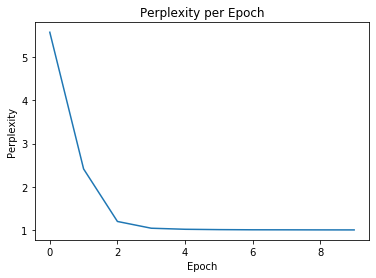

In [124]:
plot_perplexity(dev_perplexities)

# Attention visualization


In [0]:
def plot_heatmap(src, trg, scores):

    fig, ax = plt.subplots(figsize=(50,50))
    heatmap = ax.pcolor(scores, cmap='PuRd')

    ax.set_xticklabels(trg, minor=False, rotation='vertical', size=50)
    ax.set_yticklabels(src, minor=False,size=50)

    # put the major ticks at the middle of each cell
    # and the x-ticks on top
    ax.xaxis.tick_top()
    ax.set_xticks(np.arange(scores.shape[1]) + 0.5, minor=False)
    ax.set_yticks(np.arange(scores.shape[0]) + 0.5, minor=False)
    ax.invert_yaxis()

    cbar=plt.colorbar(heatmap)
    cbar.ax.tick_params(labelsize=50, width=2)
    plt.show()

src eight four four
ref [8 4 4]
pred [8 4 4]


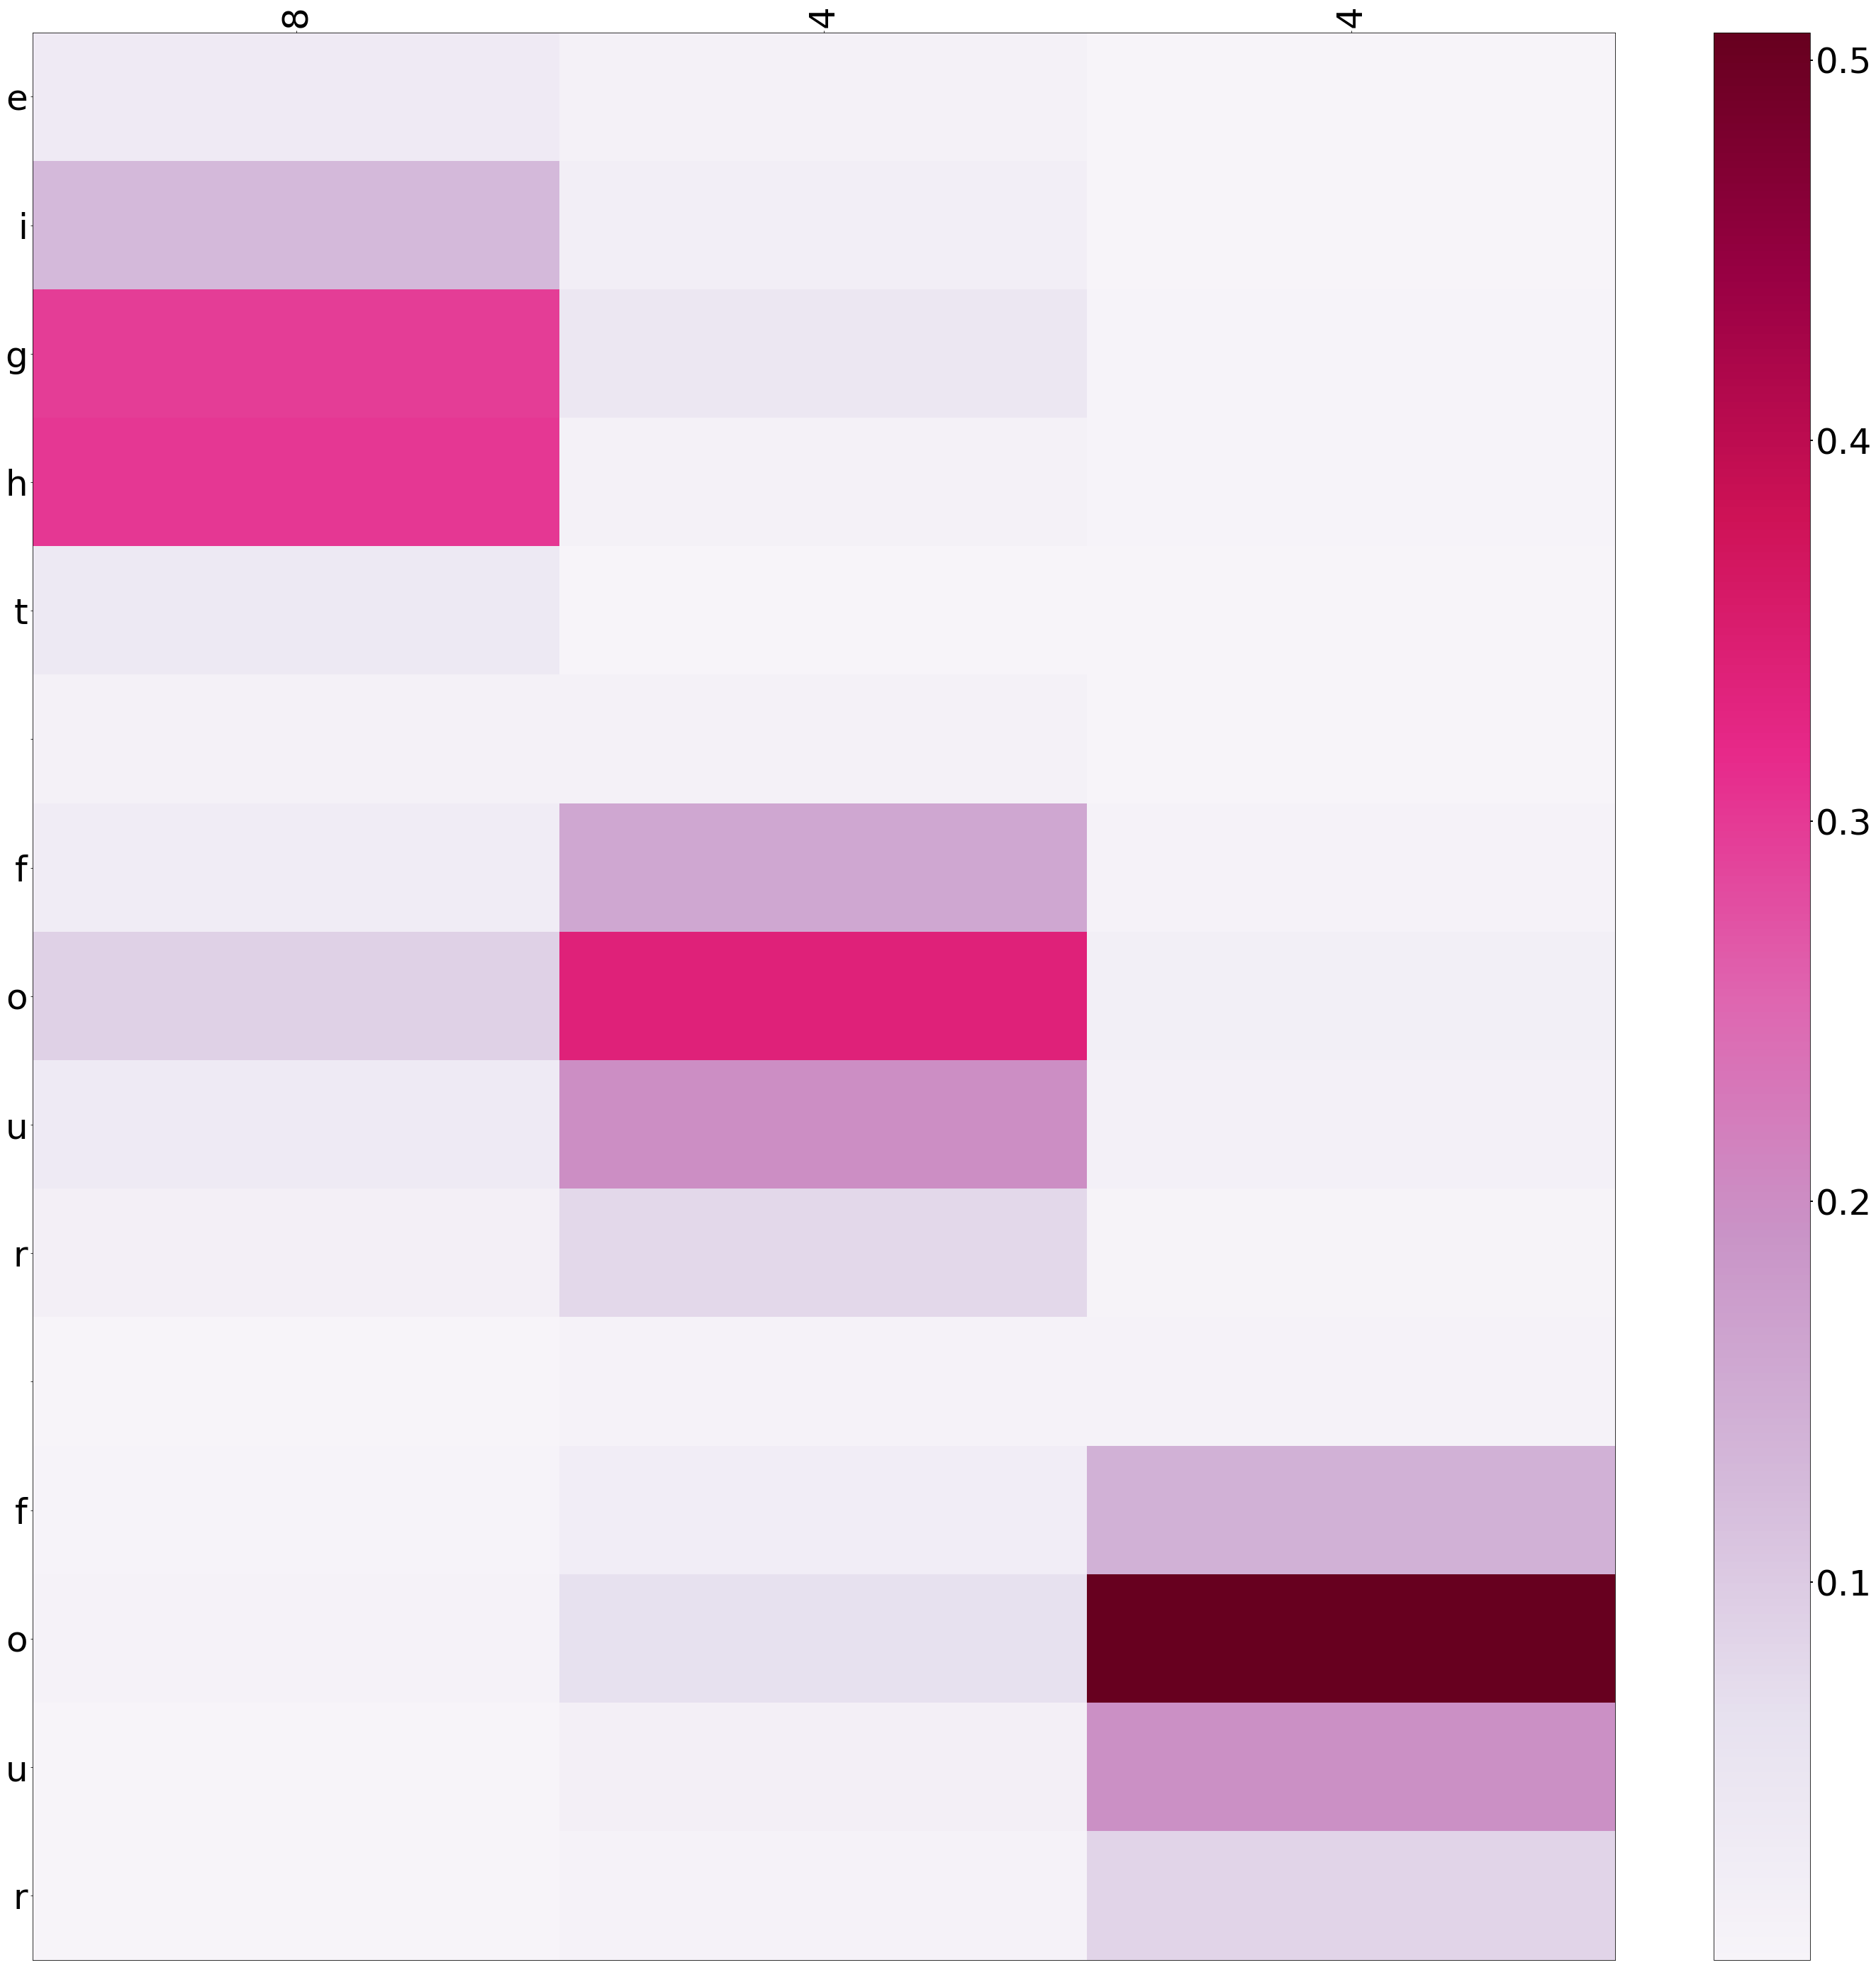

In [126]:
# This plots a chosen sentence, for which we saved the attention scores above.

src_text = "".join(turn_num_to_text(src_ex))
pred_ex = hypotheses[0]
pred_attn = alphas[0][0].T[:, :len(pred_ex)]

print("src", src_text)
print("ref", trg_ex)
print("pred", pred_ex)
plot_heatmap(src_text, pred_ex, pred_attn)
